In [74]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from alpha_vantage.timeseries import TimeSeries
from datetime import date, timedelta

In [76]:
def download_data(tickers, function='TIME_SERIES_INTRADAY', interval='5min', apikey=None):
    if apikey is None:
        apikey = os.getenv('ALPHA_VANTAGE_API_KEY')
    
    if not apikey:
        raise ValueError("API key must be provided either as an argument or through the environment variable 'ALPHA_VANTAGE_API_KEY'.")

    ts = TimeSeries(key=apikey, output_format='pandas')
    data = {}
    for ticker in tickers:
        try:
            ticker_data, _ = ts.get_daily(symbol=ticker, outputsize='full')
            ticker_data['Ticker'] = ticker
            data[ticker] = ticker_data
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    
    return pd.concat(data.values(), ignore_index=True)

In [78]:
end_date = date.today()
start_date = end_date - timedelta(days=365)

print(f'Data to be analyzed is From {start_date} To {end_date}')

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

Data to be analyzed is From 2023-08-13 To 2024-08-12


In [80]:
tickers = ['AAPL', 'MSFT', 'NFLX', 'GOOG', 'TSLA']
data = download_data(tickers)
data = data.reset_index()

ValueError: API key must be provided either as an argument or through the environment variable 'ALPHA_VANTAGE_API_KEY'.

In [44]:
data.head(10)

,1. open,2. high,3. low,4. close,5. volume,Ticker
date,,,,,,
2024-08-09,212.10,216.780,211.97,216.24,42201646.0,AAPL
2024-08-08,213.11,214.200,208.83,213.31,47161149.0,AAPL
2024-08-07,206.90,213.640,206.39,209.82,63516417.0,AAPL
2024-08-06,205.30,209.990,201.07,207.23,69660488.0,AAPL
2024-08-05,199.09,213.500,196.00,209.27,119548589.0,AAPL
2024-08-02,219.15,225.600,217.71,219.86,105568560.0,AAPL
2024-08-01,224.37,224.480,217.02,218.36,62500996.0,AAPL
2024-07-31,221.44,223.820,220.63,222.08,50036262.0,AAPL
2024-07-30,219.19,220.325,216.12,218.80,41643840.0,AAPL


In [46]:
data['date'] = pd.to_datetime(data['date'])
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

data.set_index('date', inplace=True)

KeyError: 'date'

In [ ]:
data.head(10)

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(15, 6))
for ticker in tickers:
    subset = data[data['Ticker'] == ticker]
    plt.plot(subset.index, subset['4. close'], label=ticker)

plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 6))
for ticker in data['Ticker'].unique():
    subset = data[data['Ticker'] == ticker]
    plt.plot(subset.index, subset['5. volume'], label=ticker)

plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [ ]:
def detect_anomalies(df, column, threshold=2):
    df_copy = df.copy()
    df_copy['Z-score'] = zscore(df_copy[column])
    anomalies = df_copy[abs(df_copy['Z-score']) > threshold]
    return anomalies

In [ ]:
anomalies_adj_close = pd.DataFrame()
anomalies_volume = pd.DataFrame()

for ticker in tickers:
    data_ticker = data[data['Ticker'] == ticker]
    adj_close_anomalies = detect_anomalies(data_ticker, '4. close', 2)
    volume_anomalies = detect_anomalies(data_ticker, '5. volume', 2)

    anomalies_adj_close = pd.concat([anomalies_adj_close, adj_close_anomalies])
    anomalies_volume = pd.concat([anomalies_volume, volume_anomalies])

In [ ]:
anomalies_adj_close.head(10)

In [ ]:
anomalies_volume.head(10)

In [ ]:
def plot_anomalies(ticker, anomalies_adj_close, anomalies_volume):
    
    data_ticker = data[data['Ticker'] == ticker]
    adj_close_anomalies = anomalies_adj_close[anomalies_adj_close['Ticker'] == ticker]
    volume_anomalies = anomalies_volume[anomalies_volume['Ticker'] == ticker]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    ax1.plot(data_ticker.index, data_ticker['4. close'], color='blue', label='Adj Close')
    ax1.scatter(adj_close_anomalies.index, adj_close_anomalies['4. close'], color='red', label='Anomalies')
    ax1.set_title(f'{ticker} Adjusted Close Price and Anomalies')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adjusted Close Price')
    ax1.legend()

    ax2.plot(data_ticker.index, data_ticker['5. volume'], color='green', label='Volume')
    ax2.scatter(volume_anomalies.index, volume_anomalies['5. volume'], color='orange', label='Anomalies')
    ax2.set_title(f'{ticker} Trading Volume and Anomalies')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume')
    ax2.legend()

    plt.tight_layout()
    plt.show()

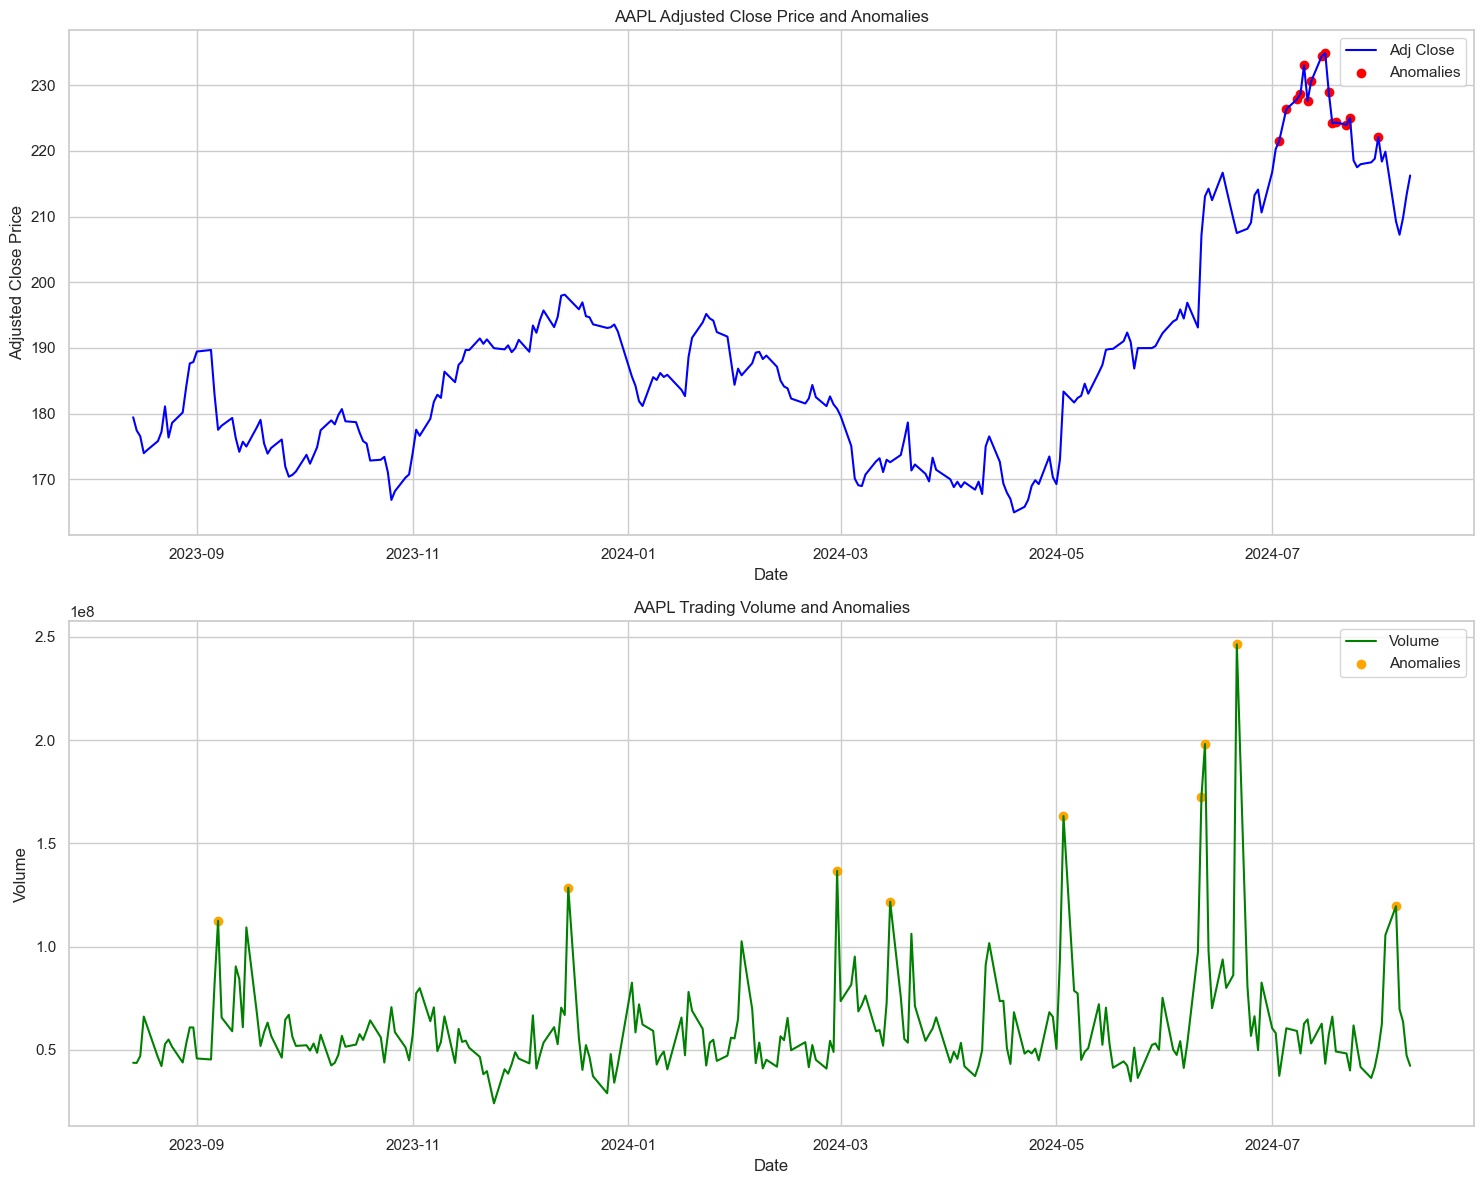

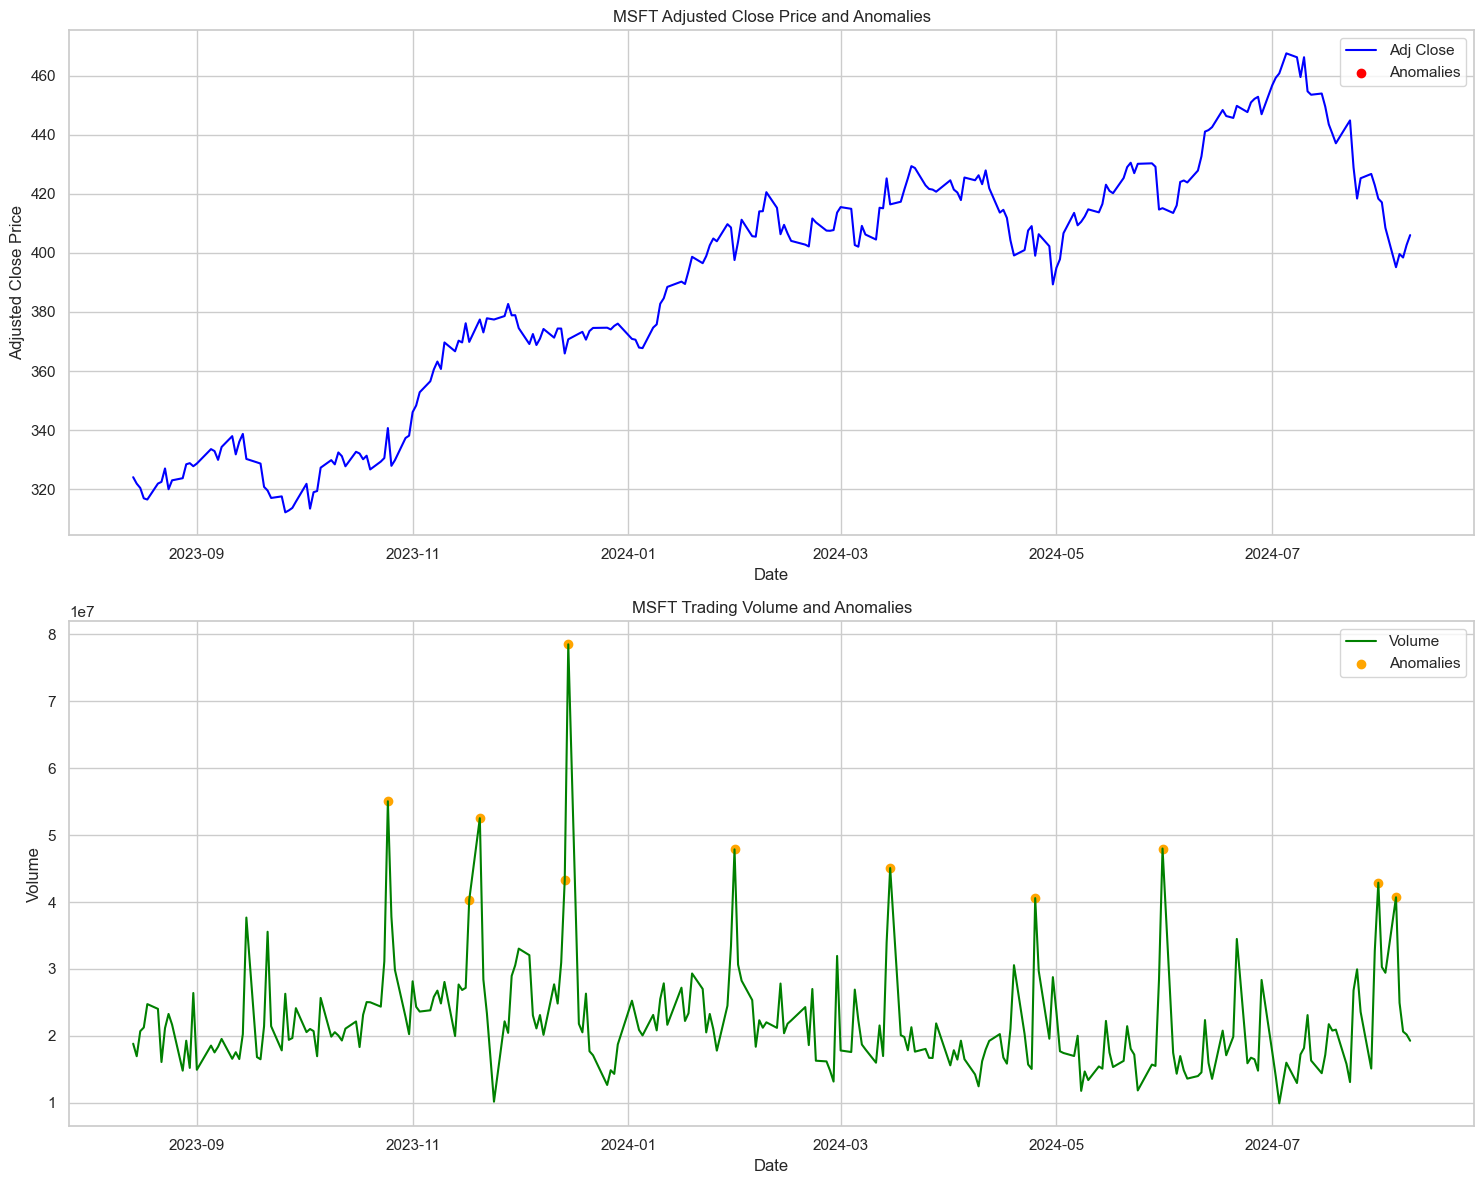

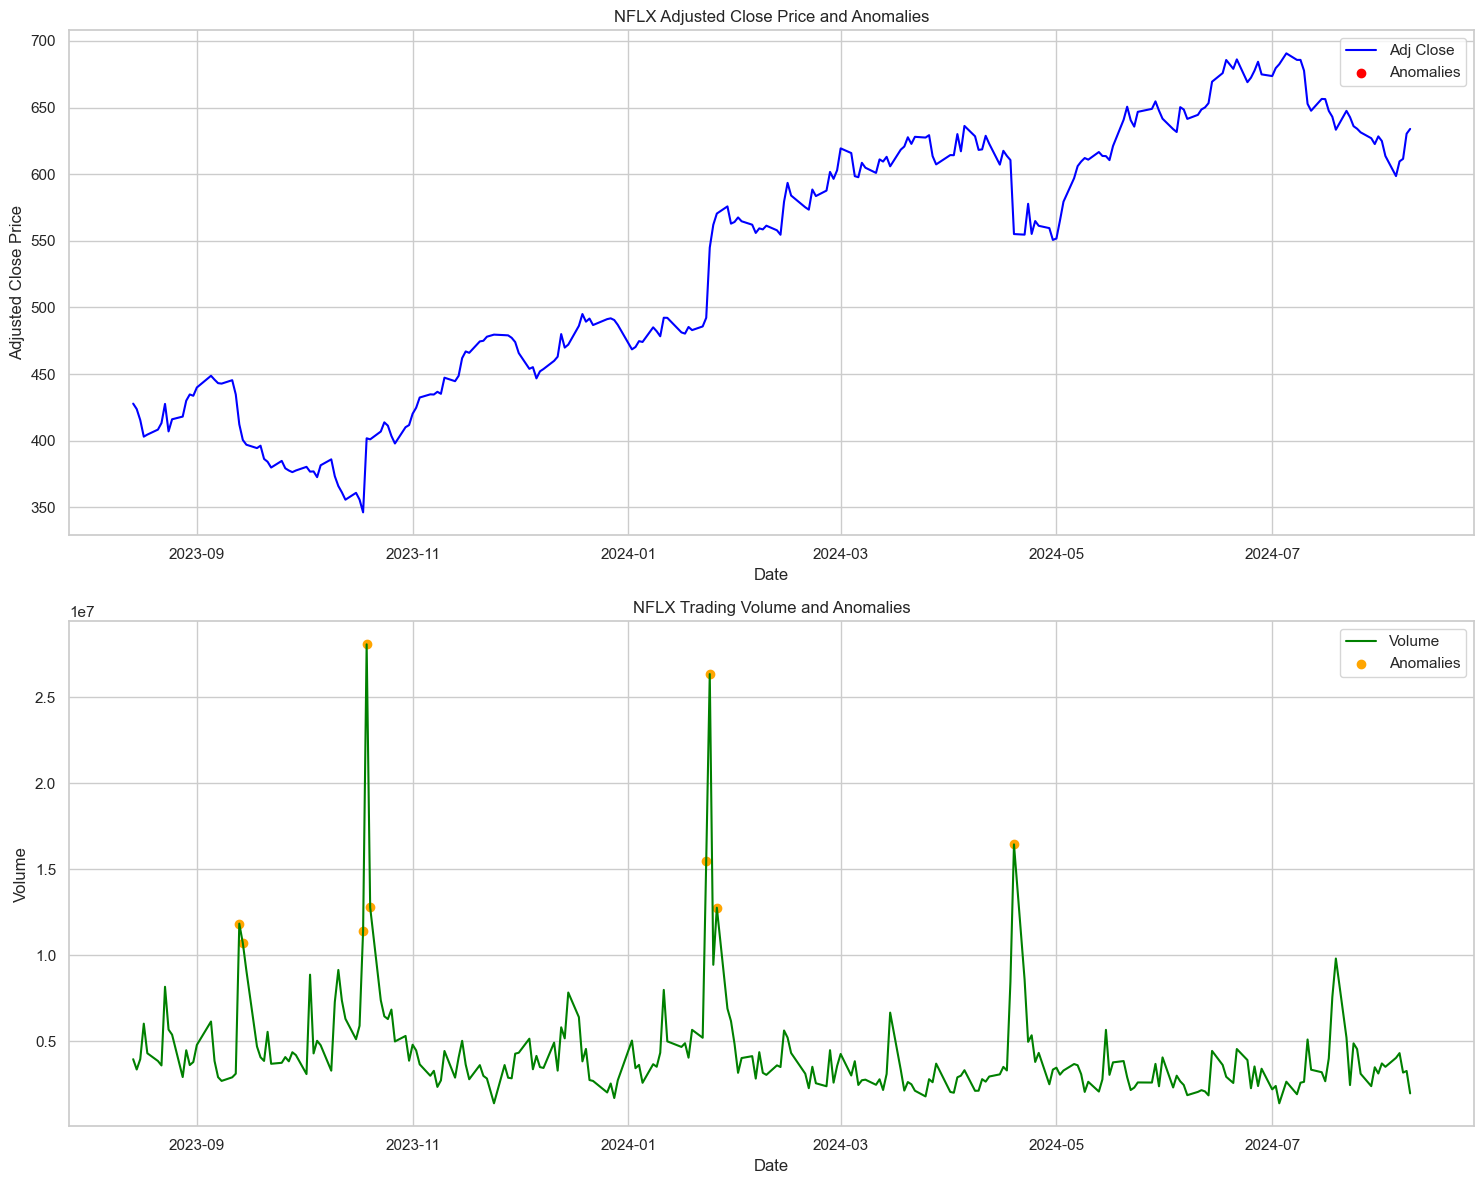

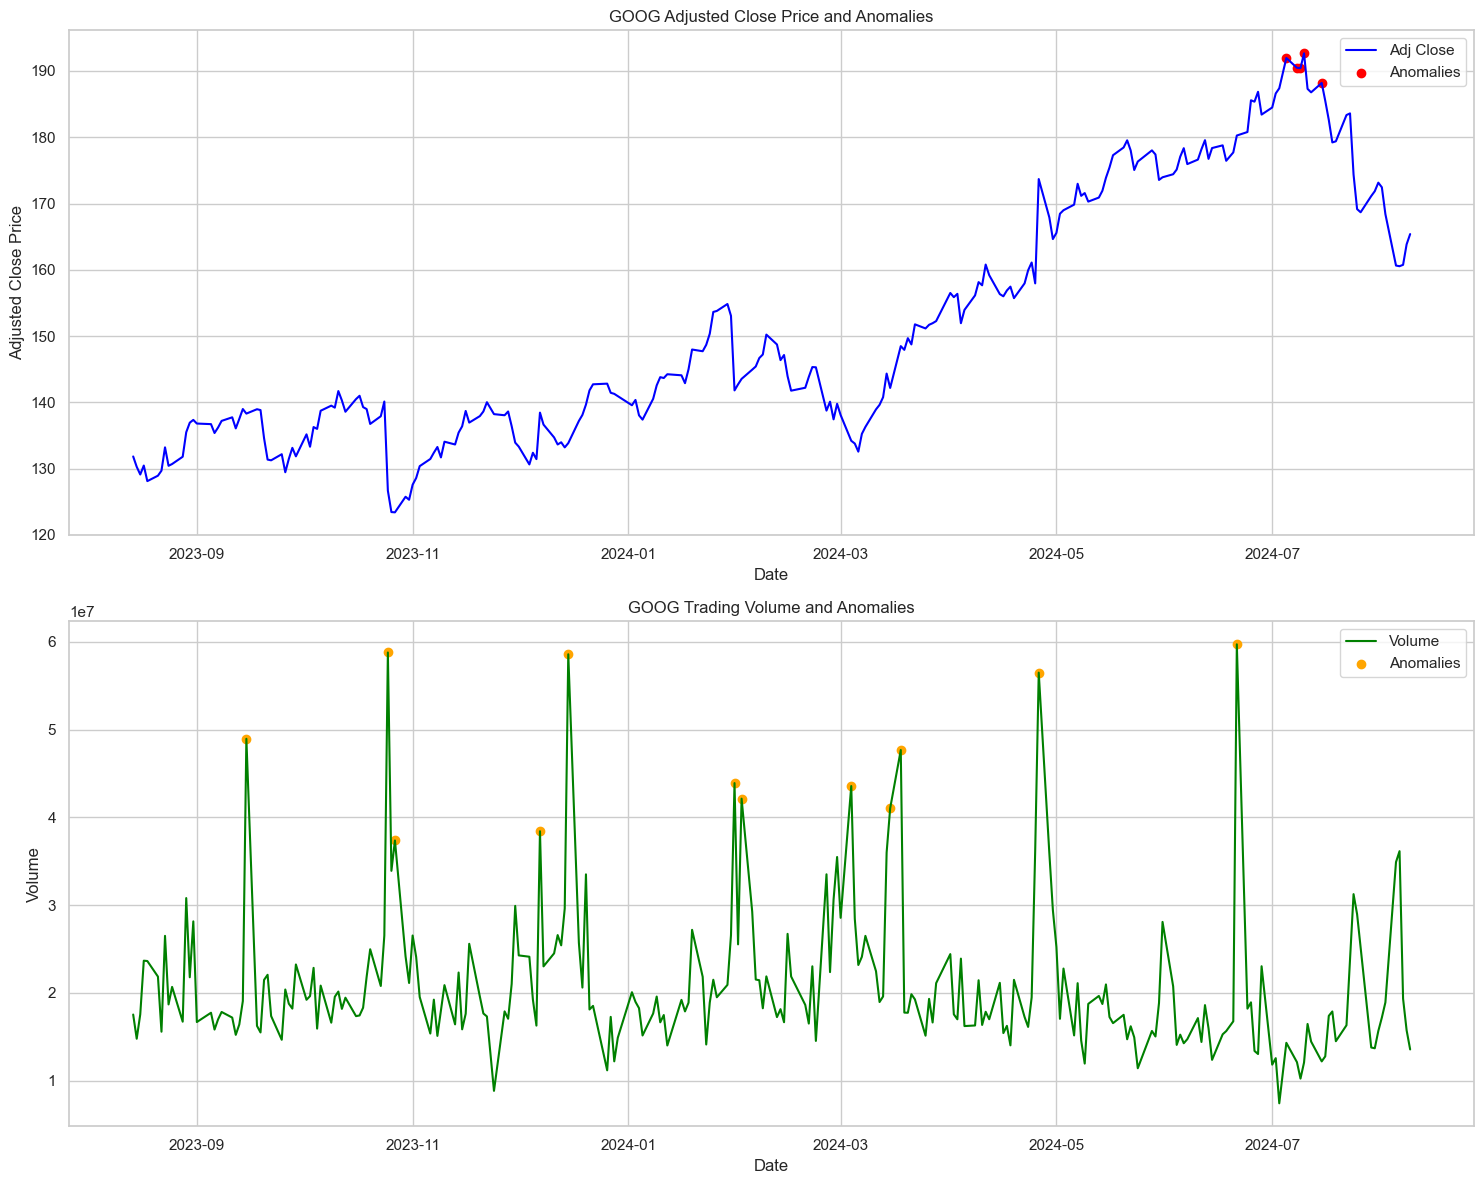

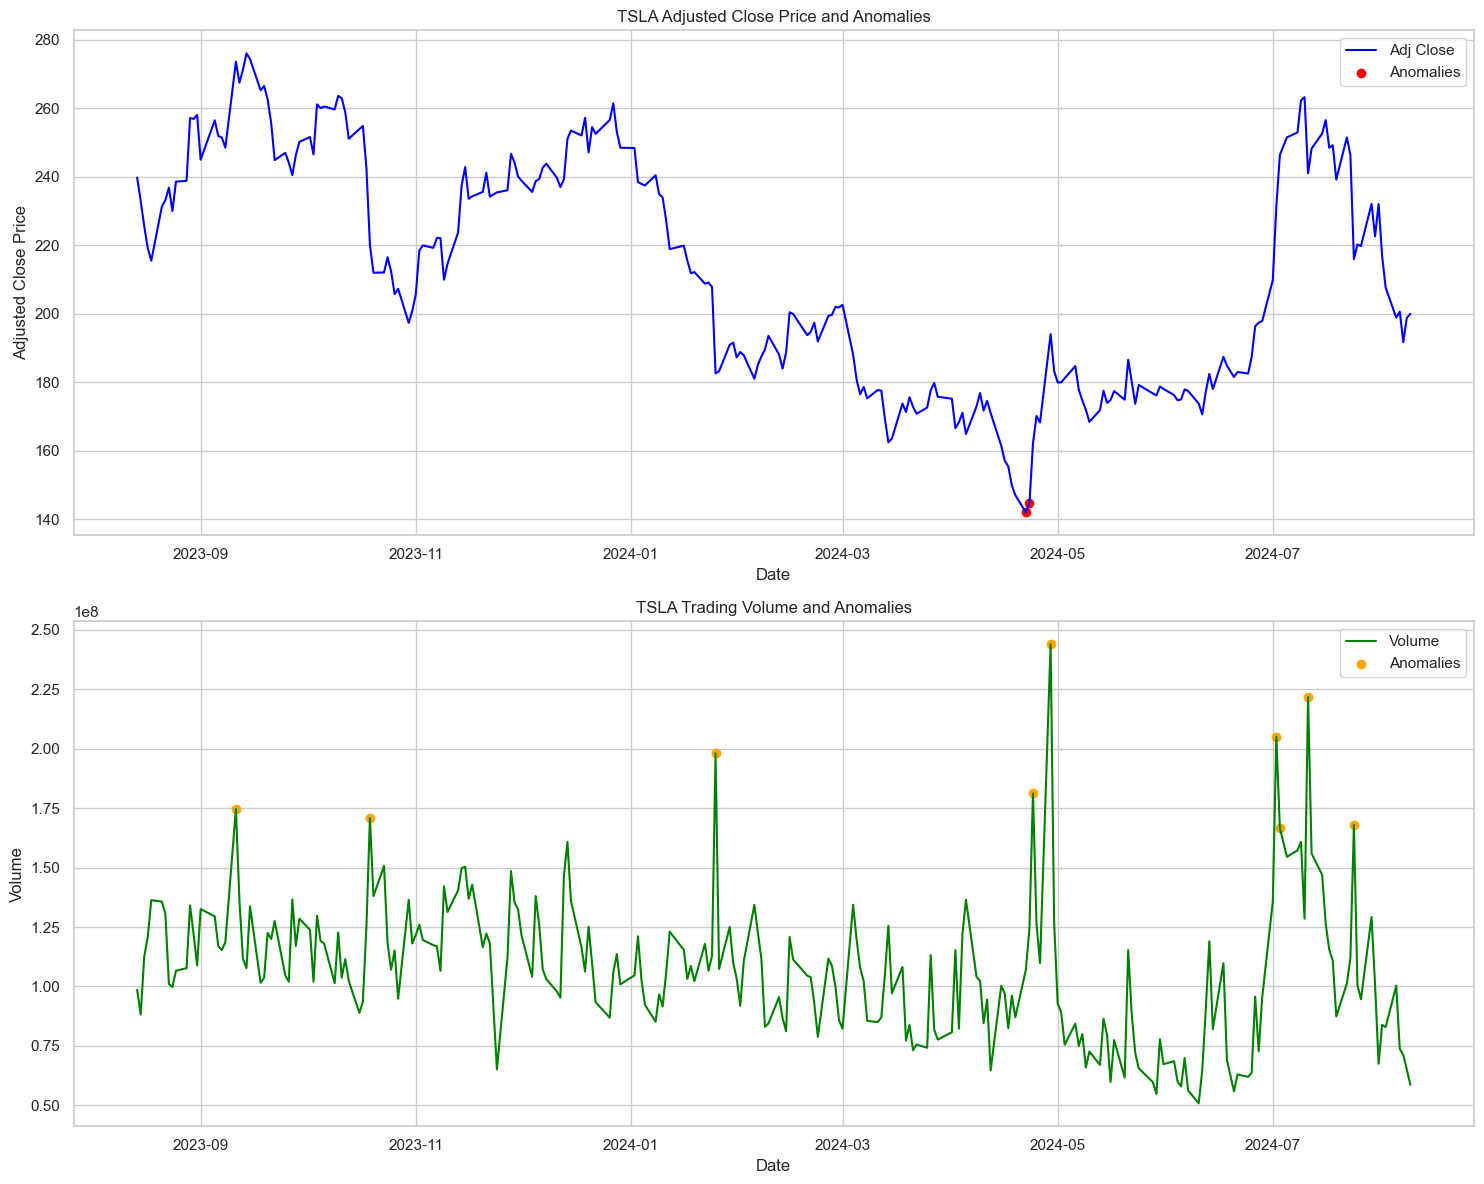

In [48]:
for ticker in tickers:
    plot_anomalies(ticker, anomalies_adj_close, anomalies_volume)

In [57]:
all_anomalies_adj_close = anomalies_adj_close[['Ticker']].copy()
all_anomalies_adj_close['Adj Close Anomaly'] = 1

all_anomalies_volume = anomalies_volume[['Ticker']].copy()
all_anomalies_volume['Volume Anomaly'] = 1

In [58]:
adj_close_pivot = all_anomalies_adj_close.pivot_table(index=all_anomalies_adj_close.index, columns='Ticker', fill_value=0, aggfunc='sum')
volume_pivot = all_anomalies_volume.pivot_table(index=all_anomalies_volume.index, columns='Ticker', fill_value=0, aggfunc='sum')

In [59]:
adj_close_pivot.columns = adj_close_pivot.columns.get_level_values(1)
volume_pivot.columns = volume_pivot.columns.get_level_values(1)

In [60]:
import plotly.graph_objects as go

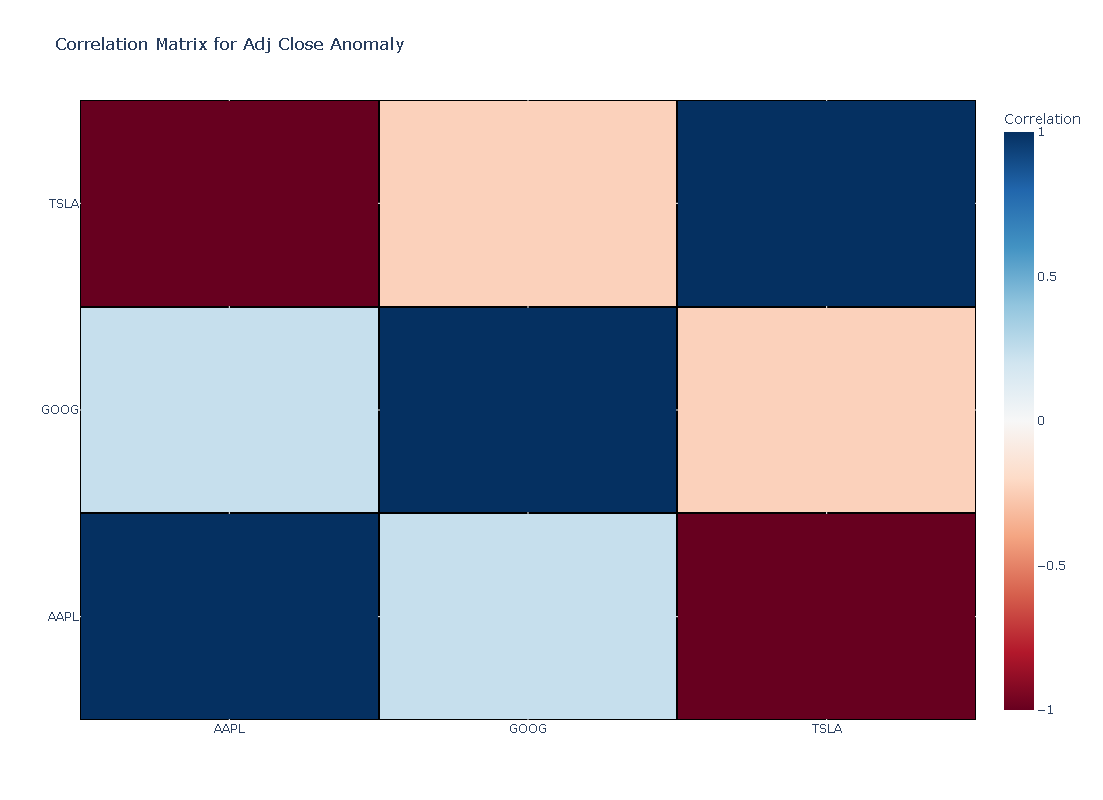

In [61]:
adj_close_correlation_matrix = adj_close_pivot.corr()

heatmap = go.Heatmap(
    z=adj_close_correlation_matrix.values,  # Use matrix values
    x=adj_close_correlation_matrix.columns,  # Set x-axis labels
    y=adj_close_correlation_matrix.columns,  # Set y-axis labels
    colorscale='RdBu',  # Color scale for correlation
    colorbar_title='Correlation',  # Colorbar title
    showscale=True,
    xgap=2,
    ygap=2
)

layout = go.Layout(
    title='Correlation Matrix for Adj Close Anomaly',
    width=1000,
    height=800,
    plot_bgcolor='black'
)

fig = go.Figure(data=[heatmap], layout=layout)
fig.show()


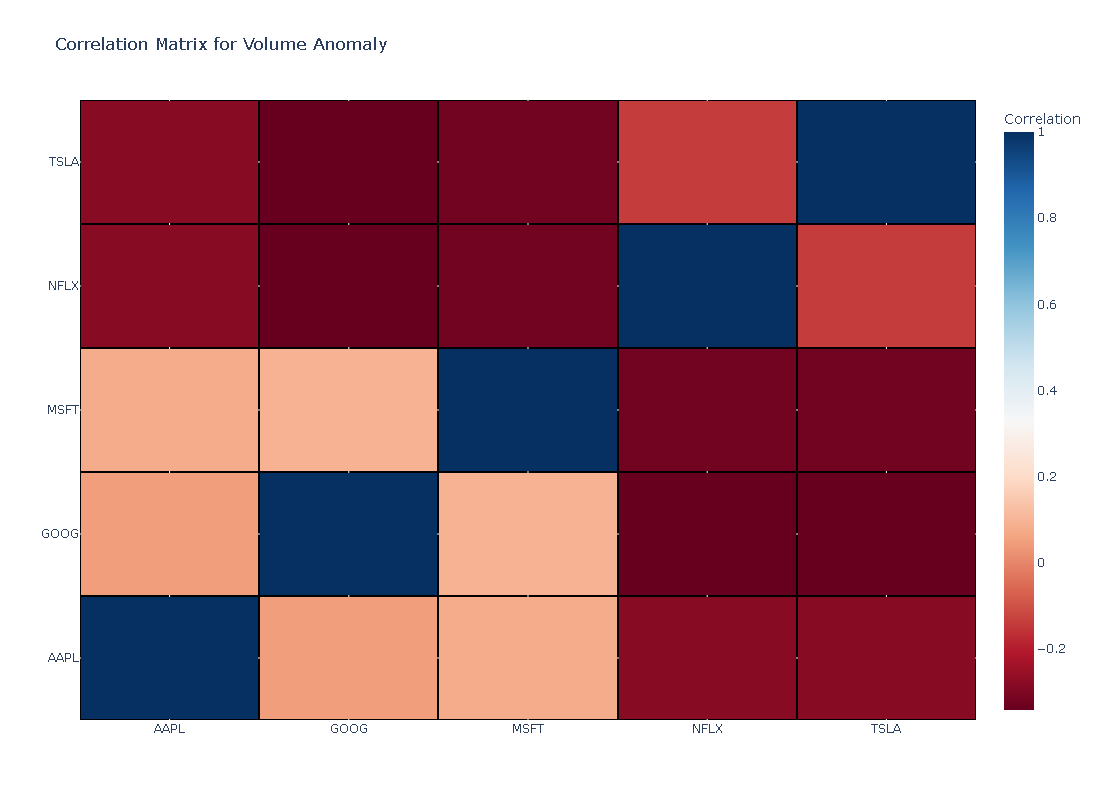

In [62]:
volume_correlation_matrix = volume_pivot.corr()

heatmap = go.Heatmap(
    z=volume_correlation_matrix.values,
    x=volume_correlation_matrix.columns,
    y=volume_correlation_matrix.columns,
    colorscale='RdBu',
    colorbar_title='Correlation',
    showscale=True,
    xgap=2,
    ygap=2
)

layout = go.Layout(
    title='Correlation Matrix for Volume Anomaly',
    width=1000,
    height=800,
    plot_bgcolor='black'
)

fig = go.Figure(data=[heatmap], layout=layout)
fig.show()

In [63]:
adj_close_risk = anomalies_adj_close.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())
volume_risk = anomalies_volume.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())
total_risk = adj_close_risk + volume_risk
risk_rating = (total_risk - total_risk.min()) / (total_risk.max() - total_risk.min())
risk_rating = pd.DataFrame(risk_rating)
risk_rating

,Z-score
Ticker,
AAPL,1.000000
GOOG,0.382851
MSFT,NaN
NFLX,NaN
TSLA,0.000000
